# 改良されたトロッター化時間発展と近似量子コンパイル（Approximate Quantum Compilation, AQC-Tensor）

**推定QPU使用時間：5分（IBM Brisbaneでテスト済み）** 

### 背景  

このチュートリアルでは、量子回路の性能向上を目的として、テンソルネットワークを用いた **近似量子コンパイル（Approximate Quantum CompilationAQC-Tensor）** をQiskitで実装する方法を紹介します。AQC-Tensorは、トロッター化時間発展の文脈で適用され、回路の深さを削減しつつ、シミュレーションの精度を維持します。本ノートブックでは、Qiskitの状態準備と最適化のフレームワークに従い、初期のトロッター回路から低深度のアンサッツ回路を作成し、それをテンソルネットワークで最適化し、量子ハードウェアでの実行に向けて準備する方法を学びます。  

本チュートリアルの主な目的は、回路の深さを削減しながらモデルハミルトニアンの時間発展をシミュレートすることです。これは、*[qiskit-addon-aqc-tensor](https://github.com/Qiskit/qiskit-addon-aqc-tensor) という **AQC-Tensor** アドオンを用いることで達成されます。このアドオンは、特に行列積状態（MPS）を活用して初期回路を圧縮・最適化します。反復的な調整を行うことで、圧縮されたアンサッツ回路は元の回路の忠実度を維持しつつ、近い将来の量子ハードウェアでも実行可能な形になります。[シンプルな例](https://docs.quantum.ibm.com/guides/qiskit-addons-aqc-get-started)と共に、詳細な[ドキュメント](https://docs.quantum.ibm.com/guides/qiskit-addons-aqc)も提供されています。  

近似量子コンパイルは、ハードウェアのコヒーレンス時間を超えるような量子シミュレーションにおいて特に有利です。これにより、複雑なシミュレーションをより効率的に実行することが可能になります。本チュートリアルでは、Qiskitを用いたAQC-Tensorワークフローのセットアップを案内し、ハミルトニアンの初期化、トロッター回路の生成、最適化された最終回路のターゲットデバイス向けトランスパイルまでをカバーします。

## 要件

このチュートリアルを開始する前に、以下がインストールされていることを確認してください：

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later
* AQC-Tensor Qiskit addon (`pip install 'qiskit-addon-aqc-tensor[aer,quimb-jax]'`)
* rustworkx 0.15 or later (`pip install rustworkx`)
* Qiskit addon utilities (`pip install qiskit-addon-utils`) (訳者追記)


## Part I. 小規模な例

このチュートリアルの最初の部分では、10サイトの小規模な例を用いて、量子シミュレーションの問題を実行可能な量子回路にマッピングするプロセスを説明します。ここでは、10サイトのXXZモデルの動力学を調べ、スケールを拡張する前に、管理しやすい量子回路を構築し最適化する方法を学びます。

XXZモデルは、スピン相互作用や磁気特性を調べるために物理学で広く研究されています。本チュートリアルでは、このモデルの開放境界条件を設定し、チェイン状の隣接サイト間にサイト依存の相互作用を持たせたハミルトニアンを構築します。

### モデルハミルトニアンと観測量

10サイトのXXZモデルに対するハミルトニアンは、以下のように定義されます：

$$
\hat{\mathcal{H}}_{XXZ} = \sum_{i=1}^{L-1} J_{i,(i+1)}\left(X_i X_{(i+1)}+Y_i Y_{(i+1)}+ 2\cdot Z_i Z_{(i+1)} \right) \, ,
$$

ここで、$J_{i,(i+1)}$はエッジ $(i, i+1)$ に対応するランダムな係数であり、サイト数は $L=10$です。

この系の時間発展を回路の深さを削減してシミュレーションすることで、AQC-Tensorを用いた回路の圧縮と最適化の有効性についての知見を得ることができます。


#### ハミルトニアンとオブザーバブルの設定

問題をマッピングする前に、10サイトのXXZモデルに対して、カップリングマップ、ハミルトニアン、オブザーバブルを設定する必要があります。

Hamiltonian: SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII'],
              coeffs=[1.        +0.j, 0.52440675+0.j, 0.52440675+0.j, 1.0488135 +0.j,
 0.60759468+0.j, 0.60759468+0.j, 1.21518937+0.j, 0.55138169+0.j,
 0.55138169+0.j, 1.10276338+0.j, 0.52244159+0.j, 0.52244159+0.j,
 1.04488318+0.j, 0.4618274 +0.j, 0.4618274 +0.j, 0.9236548 +0.j,
 0.57294706+0.j, 0.57294706+0.j, 1.14589411+0.j, 0.46879361+0.j,
 0.46879361+0.j, 0.93758721+0.j, 0.6958865 +0.j, 0.6958865 +0.j,
 1.391773  +0.j, 0.73183138+0.j, 0.73183138+0.j, 1.46366276+0.j])
Observable: SparsePauliOp(['IIIIZZIIII'],
              coeffs=[1.+0.j])


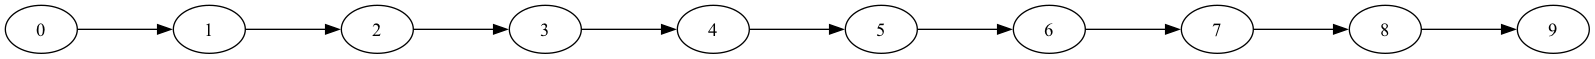

In [1]:
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw
import numpy as np

# Lはサイトの数であり、1次元スピン鎖の長さでもある。
L = 10  

# カップリング・マップの作成
elist = [(i - 1, i) for i in range(1, L)]

# HW効率の良い回路を作るために、エッジ・カラーリングを生成する。
even_edges = elist[::2]
odd_edges = elist[1::2]
coupling_map = CouplingMap(elist)

# XXZハミルトニアンのランダム係数を生成する。
np.random.seed(0)
Js = np.random.rand(L - 1) + 0.5 * np.ones(L - 1)
hamiltonian = SparsePauliOp(Pauli("I" * L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
        [
            ("XX", (edge), Js[i] / 2),
            ("YY", (edge), Js[i] / 2),
            ("ZZ", (edge), Js[i]),
        ],
        num_qubits=L,
    )

#  2つの中間量子ビット間でZZオブザーバブルを生成する。
observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L // 2 - 1, L // 2), 1.0)], num_qubits=L
)

print("Hamiltonian:", hamiltonian)
print("Observable:", observable)
graphviz_draw(coupling_map.graph, method="circo")


ハミルトニアンが定義されたので、初期状態の構築に進むことができます。

In [2]:
from qiskit import QuantumCircuit

# 初期状態を生成する
initial_state = QuantumCircuit(L)
for i in range(L):
    if i % 2:
        initial_state.x(i)

### Step 1. 古典的な入力を量子問題にマッピングする

ハミルトニアンを構築し、スピン間相互作用や外部磁場を定義したので、AQC-Tensorのワークフローに従い、以下の3つの主要なステップを実行します：  

1. **最適化されたAQC回路の生成：**：トロッター展開を用いて初期の時間発展を近似し、その後、回路の深さを削減するために圧縮します。  
   
2. **残りの時間発展回路の作成**：初期セグメントを超えた時間領域の発展を捉える回路を構築します。  
   
3. **回路の統合**：最適化されたAQC回路と、残りの時間発展回路を統合し、実行可能な完全な時間発展回路を作成します。  

この手法により、ターゲットとする時間発展の低深度アンサッツが得られ、近い将来の量子ハードウェアの制約内で効率的なシミュレーションが可能になります。

#### 古典的にシミュレーションする時間発展の部分を決定する

本チュートリアルの目的は、先に定義したモデルハミルトニアンの時間発展をトロッター展開でシミュレーションすることです。
これを量子ハードウェア上で効率的に実行するために、時間発展を2つのセグメントに分割します：

* **初期セグメント**：このセグメントは、$t_i = 0.0$ から $t_f = 0.2$ までの初期の部分の時間発展を扱います。行列積状態（MPS）でのシミュレーションが可能であり、AQC-Tensorを使用して効率的に「コンパイル」できます。[AQC-Tensorアドオン](https://github.com/Qiskit/qiskit-addon-aqc-tensor) を利用し、このセグメントの圧縮回路を生成します（`aqc_target_circuit` と呼ぶ）。テンソルネットワークシミュレーターを用いるため、ハードウェアリソースを消費せずに多くのトロッター層を適用可能です。本チュートリアルでは、このセグメントに対し、32ステップのトロッター展開(`aqc_target_num_trotter_steps = 32`) を設定します。  

* **続くセグメント**：このセグメントは、$t = 0.2$ から $t = 0.4$までの時間発展を扱います。量子ハードウェア上で実行するための回路（`subsequent_circuit`）として構築されます。ハードウェアの制約を考慮し、トロッター層の数を最小限に抑え、回路の深さを管理可能な範囲に収めます。本チュートリアルでは、このセグメントに対し、3ステップのトロッター展開(`subsequent_num_trotter_steps = 3`) を設定します。  

#### 分割時間（split time）の選択
$t = 0.2$ を分割時間として選択する理由は、古典シミュレーションの適用可能性と量子ハードウェアでの実行可能性のバランスを取るためです。時間発展の初期段階では、XXZモデルのもつれ（エンタングルメント）がまだ小さいため、MPSのような古典的手法で正確に近似できます。

分割時間の選択では、もつれを古典的に扱えるが、量子回路の簡略化に十分な時間発展を含むポイントを選ぶのが良い指針となります。異なるハミルトニアンごとに最適な分割時間は異なるため、試行錯誤が必要になる場合があります。

In [ ]:
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# AQC target circui（初期セグメント）の生成
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

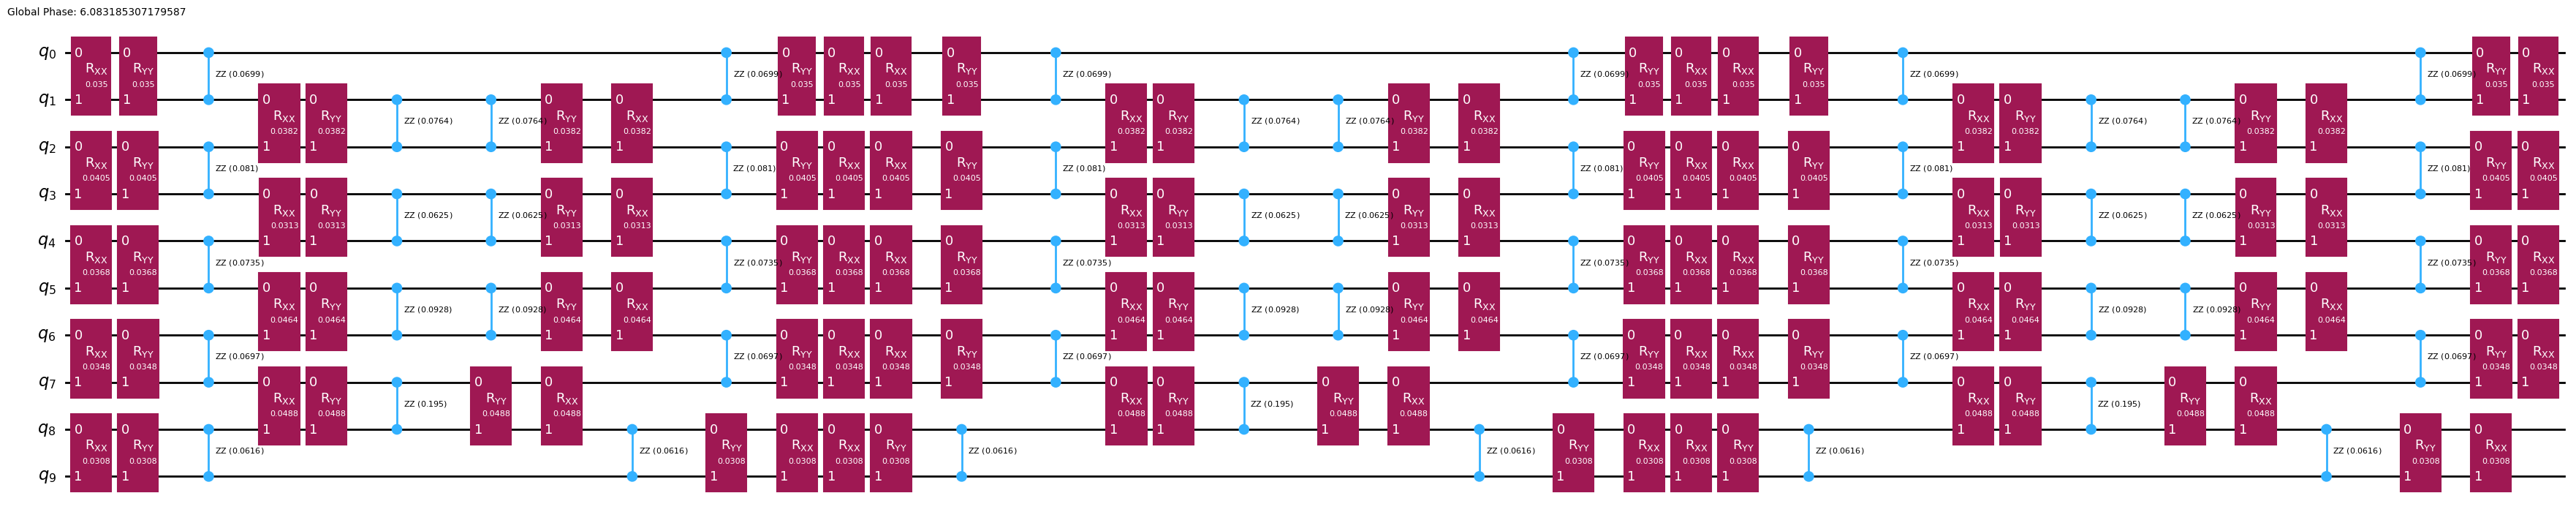

In [4]:
# subsequent circuitを生成する
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )
subsequent_circuit.draw("mpl", fold=-1)

比較を意味のあるものにするために、以下の2つの追加回路を生成します。  

* **AQC比較回路（AQC Comparison Circuit）**：`aqc_evolution_time` までの時間発展を行いますが、`subsequent_circuit` と同じトロッター時間ステップを使用します。AQC-Tensorを使用せずに時間発展を行った場合に観測される結果を示し、`aqc_target_circuit` との比較に用います。この回路を `aqc_comparison_circuit` と呼びます。  

* **参照回路（Reference Circuit）**：厳密な結果を得るための基準回路として機能します。テンソルネットワークを用いて完全な時間発展をシミュレーションし、AQC-Tensorの有効性を評価するための参照データを提供します。この回路を `reference_circuit` と呼びます。

In [5]:
# AQC comparison circuitの作成
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
print("Number of Trotter steps for comparison:", aqc_comparison_num_trotter_steps)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


In [6]:
# reference circuitの作成
evolution_time = 0.4
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

#### トロッター回路のステップ数を減らしたアンサッツと初期パラメータの生成

これまでに4つの回路を構築したので、AQC-Tensorのワークフローを進めていきます。まず、ターゲット回路（`aqc_target_circuit`）と同じ時間発展を持つが、トロッターのステップ数を減らした「良い」回路を構築します（これにより、回路の層数が少なくなる）。  

次に、この「良い」回路を AQC-Tensor の `generate_ansatz_from_circuit` 関数に渡します。この関数は、入力回路の2量子ビットの接続関係（connectivity）を解析し、以下の2つを返します。  

1. 一般的なパラメータ化されたアンサッツ回路（入力回路と同じ2量子ビット接続を持つ）。  
2. このアンサッツにパラメータを適用すると、入力の「良い」回路を再現できるような初期パラメータ。  

この後、これらのパラメータを調整しながら、アンサッツ回路がターゲットとなるMPS（行列積状態）にできるだけ近づくように最適化していきます。

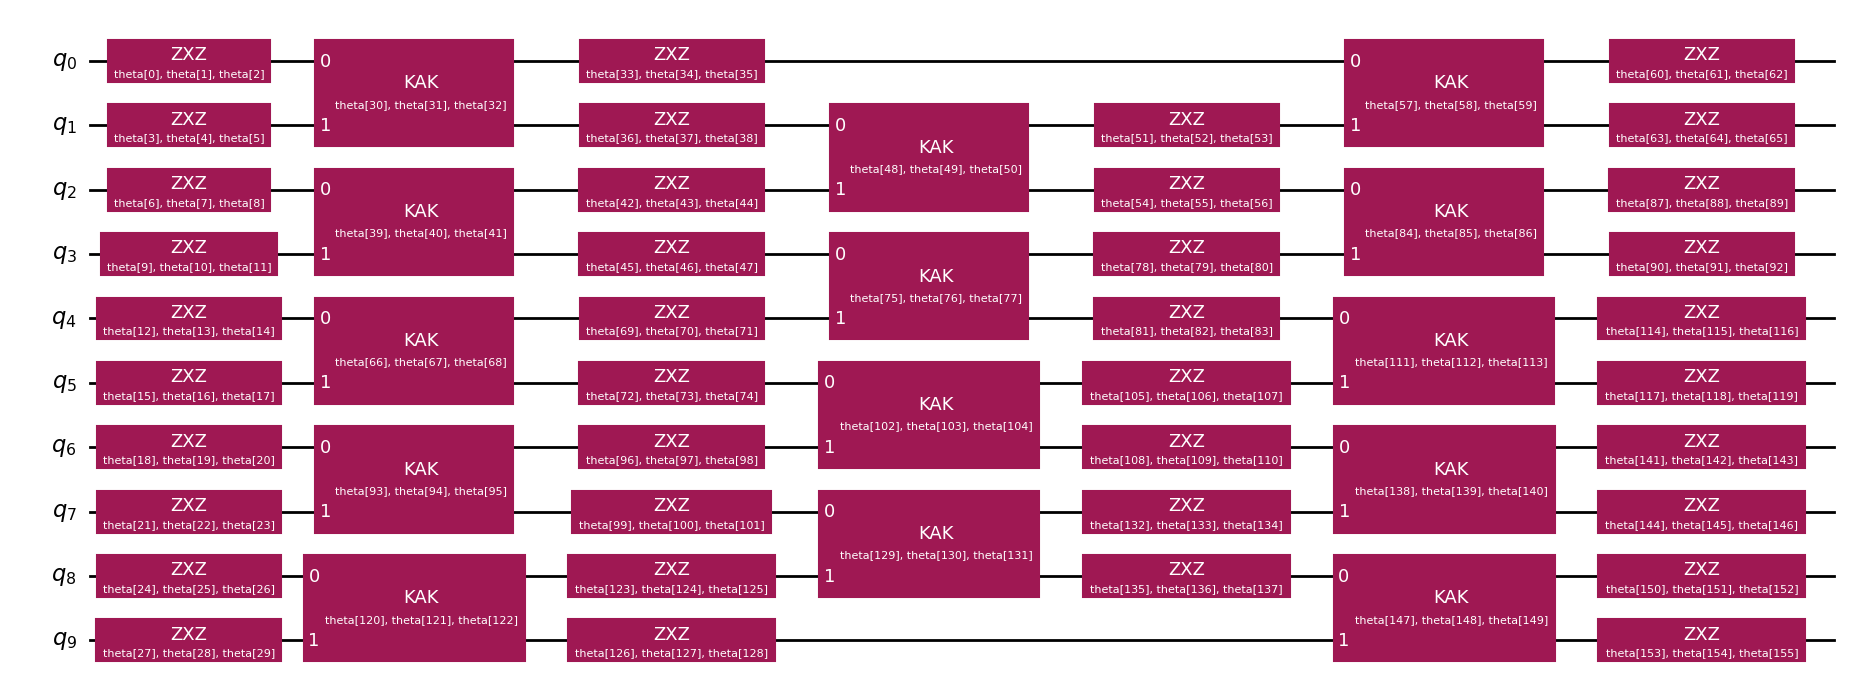

In [7]:
from qiskit_addon_aqc_tensor.ansatz_generation import generate_ansatz_from_circuit

aqc_ansatz_num_trotter_steps = 1

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(aqc_good_circuit)
aqc_ansatz.draw("mpl", fold=-1)

In [8]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")

AQC Comparison circuit: depth 36
Target circuit:         depth 385
Ansatz circuit:         depth 7, with 156 parameters


#### テンソルネットワークシミュレーションの設定を選択  
ここでは、Quimb の行列積状態（MPS）回路シミュレータを使用し、勾配計算には jax を利用します。

In [9]:
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(quimb.tensor.CircuitMPS, autodiff_backend="jax")


/Users/henryzou/.venvs/learning-aqc-1/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


次に、AQC-Tensor を用いて近似するターゲット状態の MPS（行列積状態）表現を構築します。この表現により、もつれを効率的に処理でき、量子状態をコンパクトに記述して最適化を進めることが可能になります。

In [10]:
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mps = tensornetwork_from_circuit(aqc_target_circuit, simulator_settings)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# 参照MPS（行列積状態）を取得し、`local_expectation` を調べることで正確な期待値を得ることができます。
reference_mps  = tensornetwork_from_circuit(reference_circuit, simulator_settings)
reference_expval = reference_mps.local_expectation(quimb.pauli('Z') & quimb.pauli('Z'), (L // 2 - 1, L // 2)).real.item()
print("Reference MPS maximum bond dimension:", reference_mps.psi.max_bond())

Target MPS maximum bond dimension: 5
Reference MPS maximum bond dimension: 7


ターゲット状態に対してより多くのトロッターステップを選択することにより、初期回路と比較してトロッター誤差を効果的に減少させたことに注意してください。この違いを定量化するために、初期回路で準備された状態とターゲット状態の間の忠実度($|\langle \psi_1 | \psi_2 \rangle|^2$)を評価することができます。

In [11]:
from qiskit_addon_aqc_tensor.simulation import compute_overlap

good_mps = tensornetwork_from_circuit(aqc_good_circuit, simulator_settings)
starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
print("Starting fidelity:", starting_fidelity)

Starting fidelity: 0.9982464959067983


#### MPS計算を用いてアンサッツのパラメータを最適化する 

このステップでは、L-BFGS最適化アルゴリズム（SciPyのもの）を使用して、簡単なコスト関数`OneMinusFidelity`を最小化することにより、アンサッツのパラメータを最適化します。忠実度の停止基準を選択し、AQC-Tensorを使用しない初期回路の忠実度を超えることを確実にします。この閾値に達した時点で、圧縮された回路は、元の回路と比較してトロッター誤差が小さく、回路深度が低くなることが期待されます。追加のCPU時間を使用することで、さらなる最適化が行われ、忠実度をさらに向上させることができます。

In [12]:
import datetime
from scipy.optimize import OptimizeResult, minimize
from qiskit_addon_aqc_tensor.objective import OneMinusFidelity

# 最適化のための値の設定
aqc_stopping_fidelity = 1
aqc_max_iterations = 500

stopping_point = 1.0 - aqc_stopping_fidelity
objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)

def callback(intermediate_result: OptimizeResult):
    fidelity = 1 - intermediate_result.fun
    print(f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration
    
result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": aqc_max_iterations},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

2024-11-12 12:25:24.948924 Intermediate result: Fidelity 0.99952846
2024-11-12 12:25:24.950982 Intermediate result: Fidelity 0.99958508
2024-11-12 12:25:24.952984 Intermediate result: Fidelity 0.99959974
2024-11-12 12:25:24.954757 Intermediate result: Fidelity 0.99960963
2024-11-12 12:25:24.956520 Intermediate result: Fidelity 0.99962441
2024-11-12 12:25:24.958425 Intermediate result: Fidelity 0.99964395
2024-11-12 12:25:24.960344 Intermediate result: Fidelity 0.99968078
2024-11-12 12:25:24.964133 Intermediate result: Fidelity 0.99970510
2024-11-12 12:25:24.966034 Intermediate result: Fidelity 0.99973847
2024-11-12 12:25:24.967835 Intermediate result: Fidelity 0.99975444
2024-11-12 12:25:24.970126 Intermediate result: Fidelity 0.99976553
2024-11-12 12:25:24.972458 Intermediate result: Fidelity 0.99977638
2024-11-12 12:25:24.974268 Intermediate result: Fidelity 0.99978698
2024-11-12 12:25:24.976094 Intermediate result: Fidelity 0.99980260
2024-11-12 12:25:24.978092 Intermediate result: 

In [13]:
parameters = [float(param) for param in aqc_final_parameters]
print("Final parameters:", parameters)

Final parameters: [-7.853981112055085, 1.570797507204238, 1.5707979087614174, -1.5707952787358048, 1.5707970310387784, 1.57079522775084, -1.5707961623743325, 1.5707967336614768, -1.570796611087232, -1.5707962145893895, 1.570796271703914, 4.712387929822417, -7.853982402563732, 1.5707989095671329, 1.5707977385737681, -1.5707940741962412, 1.570797314941096, 1.5707976541580273, -1.5707933229425972, 1.5707961058359217, -1.5707958413362826, -1.570795089655074, 1.5707976787480016, 4.712387191305782, -1.5707946890053843, 1.5707953450204197, -1.5707992793567143, -1.570796265954742, 1.5707947949425147, 4.712390321753913, 0.10487779951457206, 0.0669304855960779, -0.06692189478829999, -3.1415924255843914, 2.609868292582522, -1.1234832406759191e-07, -3.141591645153891, 0.9422894740075248, -2.1314672866019113e-07, 0.12151543373326927, 0.07942604019639618, -0.07943027847071561, -3.1415916298284436, 0.9741837915058525, 3.141591718418538, -1.1550376470679338e-06, 1.7897358800047758, 2.1195414839490685e

この時点では、アンサッツ回路の最終的なパラメーターを求めるだけです。その後、最適化されたAQC回路と残りの時間発展回路を統合して、量子ハードウェアで実行するための完全な時間発展回路を作成します。

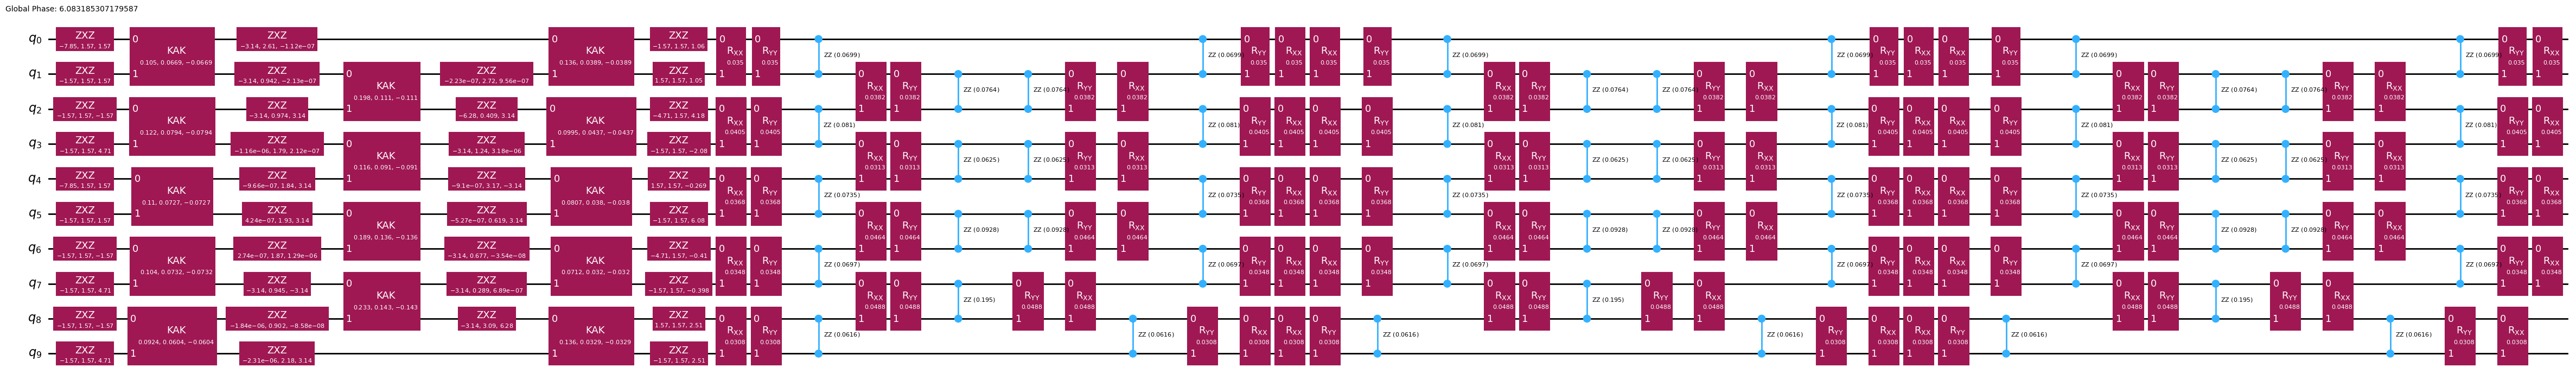

In [14]:
aqc_final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)
aqc_final_circuit.draw("mpl", fold=-1)

`aqc_comparison_circuit` についても、残りの時間発展回路と統合する必要があります。この回路は、AQC-Tensorで最適化された回路と元の回路の性能を比較するために使用されます。

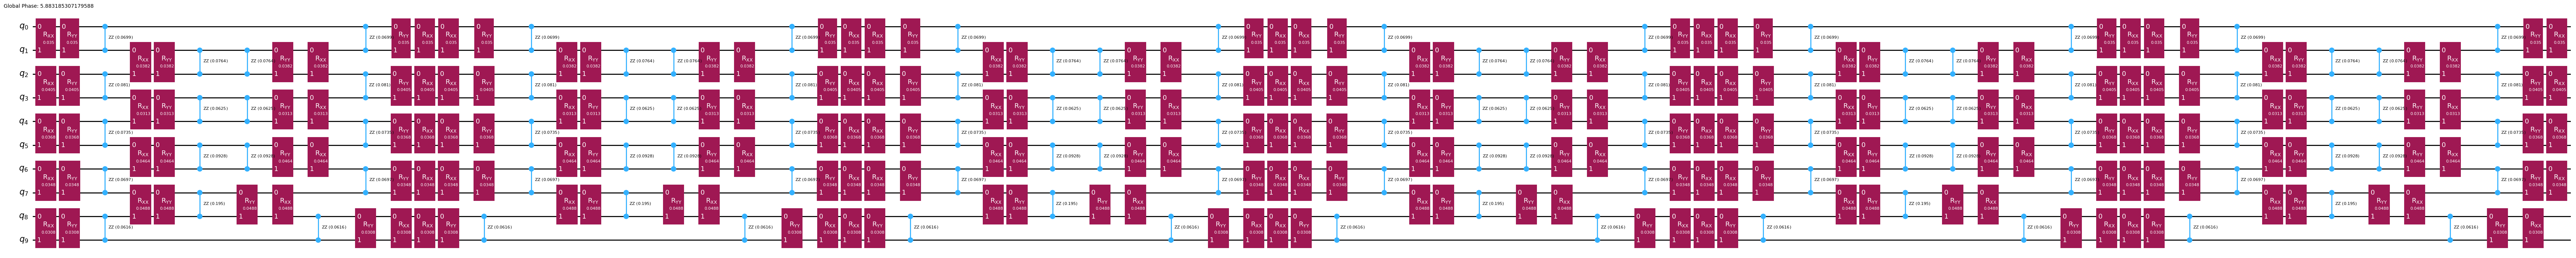

In [15]:
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

### ステップ2. 量子実行のために問題を最適化する


ここでは、少なくとも127量子ビットを持つIBM Quantumデバイスのいずれかを使用します。

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_brisbane')>


PUBs(回路とオブザーバブル)をバックエンドのISA（Instruction Set Architecture, 命令セットアーキテクチャ）に一致させるためにトランスパイルします。`optimization_level=3` を設定することで、トランスパイラーは回路を1次元の量子ビットチェーンに適合させ、回路の忠実度に影響を与えるノイズを削減します。回路がバックエンドと互換性のある形式に変換された後、変更された量子ビットのレイアウトに一致するようにオブザーバブルにも対応する変換を適用します。


Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j])
Circuit depth: 121


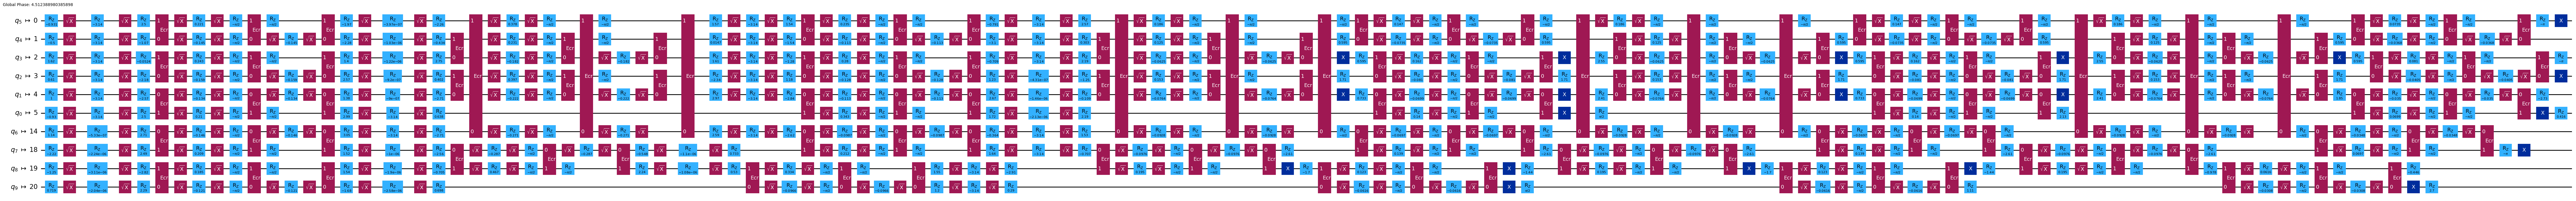

In [17]:
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

比較回路(aqc_comparison_circuit)のトランスパイルを実行します。

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[1.+0.j])
Circuit depth: 157


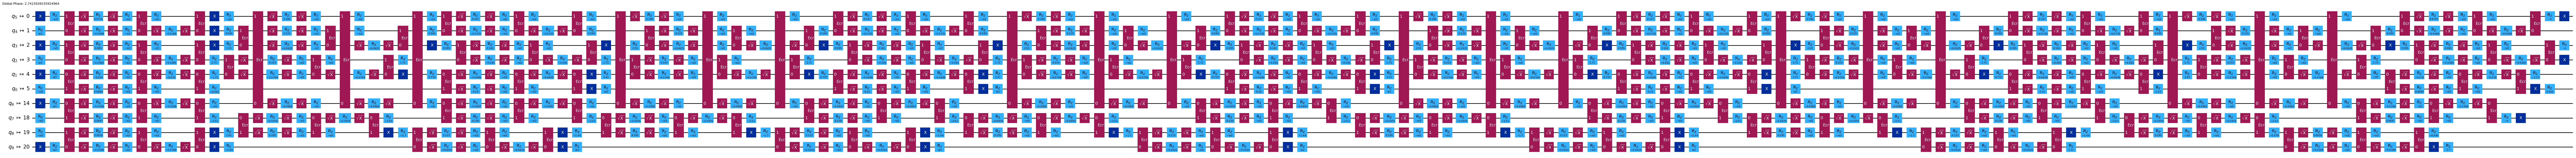

In [18]:
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(isa_comparison_circuit.layout)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)


#### Step 3. Qiskit Primitives を使用して実行する

このステップでは、トランスパイルされた回路を量子ハードウェア（またはシミュレートされたバックエンド）で実行します。  
`qiskit_ibm_runtime` の `EstimatorV2` クラスを使用して、回路を実行し、指定されたオブザーバブルを測定するためのestimatorを設定します。ジョブの結果として、オブザーバブルの期待される結果が得られ、ターゲットハードウェア上での回路の性能についての洞察を得ることができます。

In [19]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend)
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: cwsrz54ehebg008j5jz0


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

比較回路の実行を行います。

In [20]:
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()


Job Comparison ID: cwsrz54ehebg008j5jz0


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

### Step 4. 後処理、結果を古典的な形式で返す

この場合、再構築は不要です。実行結果から期待値にアクセスすることで、直接結果を確認できます。



In [21]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [pub_result.data.__dict__ for pub_result in hw_comparison_results]
hw_comparison_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_comparison_results_dicts]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}")
print(f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}")

Exact:         	-0.5252
AQC:           	-0.5033, |∆| = 0.0220
AQC Comparison:	0.4317, |∆| = 0.9569


AQC回路、比較回路、厳密回路の結果を比較するための棒グラフ。

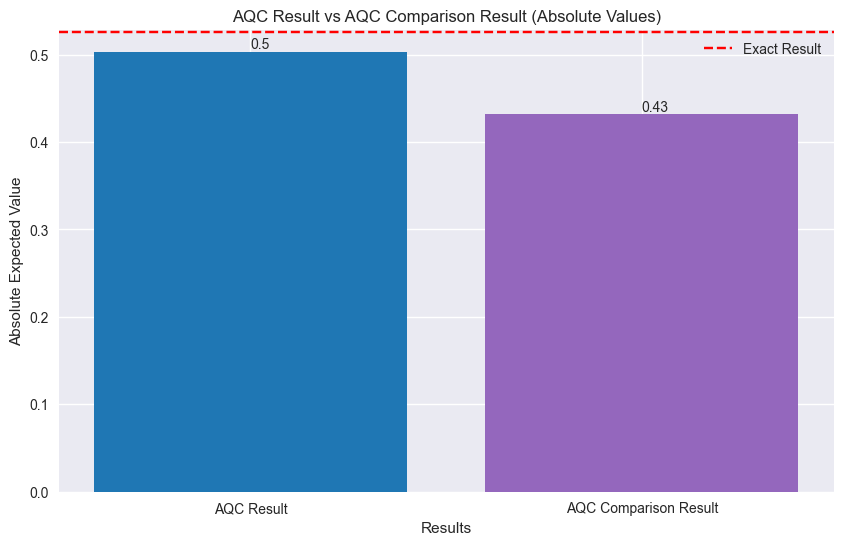

In [22]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

labels = ['AQC Result', 'AQC Comparison Result']
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['tab:blue', 'tab:purple'])
plt.axhline(y=abs(reference_expval), color='red', linestyle='--', label='Exact Result')
plt.xlabel('Results')
plt.ylabel('Absolute Expected Value')
plt.title('AQC Result vs AQC Comparison Result (Absolute Values)')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  
plt.show()

## Part II: スケールアップ！

このチュートリアルの第二部では、前の例を基に、50サイトのより大きなシステムにスケールアップし、より複雑な量子シミュレーション問題を実行可能な量子回路にマッピングする方法を示します。ここでは、50サイトのXXZモデルの動力学を探り、より現実的なシステムサイズを反映した大規模な量子回路を構築・最適化します。

50サイトXXZモデルのハミルトニアンは次のように定義されます：

$$
\hat{\mathcal{H}}_{XXZ} = \sum_{i=1}^{L-1} J_{i,(i+1)}\left(X_i X_{(i+1)}+Y_i Y_{(i+1)}+ 2\cdot Z_i Z_{(i+1)} \right) \, ,
$$

ここで、$J_{i,(i+1)}$ はエッジ$(i, i+1)$に対応するランダムな係数で、$L=50$ はサイトの数です。

ハミルトニアンの結合マップとエッジを定義します。

In [ ]:
L = 50  # L = length of our 1D spin chain

# Generate the edge-list for this spin-chain
elist = [(i - 1, i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
even_edges = elist[::2]
odd_edges = elist[1::2]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(elist)

# Generate random coefficients for our XXZ Hamiltonian
np.random.seed(0)
Js = np.random.rand(L - 1) + 0.5 * np.ones(L - 1)

hamiltonian = SparsePauliOp(Pauli("I" * L))
for i, edge in enumerate(even_edges + odd_edges):
    hamiltonian += SparsePauliOp.from_sparse_list(
        [
            ("XX", (edge), Js[i] / 2),
            ("YY", (edge), Js[i] / 2),
            ("ZZ", (edge), Js[i]),
        ],
        num_qubits=L,
    )

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L // 2 - 1, L // 2), 1.0)], num_qubits=L
)

# Generate an initial state
L = hamiltonian.num_qubits
initial_state = QuantumCircuit(L)
for i in range(L):
    if i % 2:
        initial_state.x(i)

### Step 1. 古典的な入力を量子問題にマッピングする

この大規模な問題では、まず50サイトのXXZモデルのハミルトニアンを構築し、全てのサイトにわたるスピン-スピン相互作用と外部磁場を定義します。その後、以下の3つの主要なステップに従います：

1. **最適化されたAQC回路の生成**：トロッター展開を使用して初期の時間発展を近似し、このセグメントを圧縮して回路深度を削減します。
2. **残りの時間発展回路の作成**：初期セグメントを超える残りの時間発展をキャプチャします。
3. **回路の統合**：最適化されたAQC回路と残りの時間発展回路を統合して、実行準備が整った完全な時間発展回路を作成します。

AQC target circuit (初期セグメント)を生成します。


In [ ]:
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

残りのセグメント（次の回路）を生成します。

In [ ]:
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )

AQC比較回路の生成（初期セグメント、ただし次の回路と同じ数のトロッターステップを使用）。

In [26]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)
print("Number of Trotter steps for comparison:", aqc_comparison_num_trotter_steps)

aqc_comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

Number of Trotter steps for comparison: 3


参照回路を生成します。

In [27]:
evolution_time = 0.4
reps = 200

reference_circuit = initial_state.copy()
reference_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=reps),
        time=evolution_time,
    ),
    inplace=True,
)

少ないステップのトロッタ回路からアンサッツと初期パラメータを生成する。

In [ ]:
aqc_ansatz_num_trotter_steps = 1

aqc_good_circuit = initial_state.copy()
aqc_good_circuit.compose(
    generate_time_evolution_circuit(
        hamiltonian,
        synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(aqc_good_circuit)

In [29]:
print(f"AQC Comparison circuit: depth {aqc_comparison_circuit.depth()}")
print(f"Target circuit:         depth {aqc_target_circuit.depth()}")
print(f"Ansatz circuit:         depth {aqc_ansatz.depth()}, with {len(aqc_initial_parameters)} parameters")

AQC Comparison circuit: depth 36
Target circuit:         depth 385
Ansatz circuit:         depth 7, with 816 parameters


テンソルネットワークシミュレーションの設定を行い、その後、最適化のためにターゲット状態の行列積状態（MPS）表現を構築します。次に、初期回路とターゲット状態の間の忠実度を評価し、トロッター誤差の違いを定量化します。

In [ ]:
simulator_settings = QuimbSimulator(quimb.tensor.CircuitMPS, autodiff_backend="jax")

# Build the matrix-product representation of the state to be approximated by AQC
aqc_target_mps = tensornetwork_from_circuit(aqc_target_circuit, simulator_settings)
print("Target MPS maximum bond dimension:", aqc_target_mps.psi.max_bond())

# Obtains the reference MPS, where we can obtain the exact expectation value by examing the `local_expectation``
reference_mps  = tensornetwork_from_circuit(reference_circuit, simulator_settings)
reference_expval = reference_mps.local_expectation(quimb.pauli('Z') & quimb.pauli('Z'), (L // 2 - 1, L // 2)).real.item()

# Compute the starting fidelity
good_mps = tensornetwork_from_circuit(aqc_good_circuit, simulator_settings)
starting_fidelity = abs(compute_overlap(good_mps, aqc_target_mps)) ** 2
print("Starting fidelity:", starting_fidelity)

Target MPS maximum bond dimension: 5   
Starting fidelity: 0.9926466919924661

アンサッツのパラメータを最適化するために、SciPyのL-BFGS最適化アルゴリズムを使用して`OneMinusFidelity`コスト関数を最小化し、停止基準をAQC-Tensorなしで初期回路の忠実度を超えるように設定します。これにより、圧縮された回路はトロッタ誤差が小さく、回路深度が減少することが保証されます。

In [31]:
# Setting values for the optimization
aqc_stopping_fidelity = 1
aqc_max_iterations = 500

stopping_point = 1.0 - aqc_stopping_fidelity
objective = OneMinusFidelity(aqc_target_mps, aqc_ansatz, simulator_settings)

def callback(intermediate_result: OptimizeResult):
    fidelity = 1 - intermediate_result.fun
    print(f"{datetime.datetime.now()} Intermediate result: Fidelity {fidelity:.8f}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration
    
result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": aqc_max_iterations},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

2024-11-12 12:28:22.873939 Intermediate result: Fidelity 0.99795506
2024-11-12 12:28:22.887593 Intermediate result: Fidelity 0.99822850
2024-11-12 12:28:22.899789 Intermediate result: Fidelity 0.99829627
2024-11-12 12:28:22.911861 Intermediate result: Fidelity 0.99832307
2024-11-12 12:28:22.924786 Intermediate result: Fidelity 0.99835857
2024-11-12 12:28:22.936849 Intermediate result: Fidelity 0.99840204
2024-11-12 12:28:22.949555 Intermediate result: Fidelity 0.99846922
2024-11-12 12:28:22.961815 Intermediate result: Fidelity 0.99865291
2024-11-12 12:28:22.974129 Intermediate result: Fidelity 0.99872522
2024-11-12 12:28:22.986358 Intermediate result: Fidelity 0.99892264
2024-11-12 12:28:22.998510 Intermediate result: Fidelity 0.99900616
2024-11-12 12:28:23.010171 Intermediate result: Fidelity 0.99906991
2024-11-12 12:28:23.022538 Intermediate result: Fidelity 0.99911245
2024-11-12 12:28:23.034478 Intermediate result: Fidelity 0.99918525
2024-11-12 12:28:23.046888 Intermediate result: 

In [ ]:
parameters = [float(param) for param in aqc_final_parameters]

最適化されたアンサッツと残りの時間発展回路を組み合わせて、トランスパイル用の最終回路を構築します。

In [ ]:
aqc_final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
aqc_final_circuit.compose(subsequent_circuit, inplace=True)

In [ ]:
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)

### Step 2. 量子実行のために問題を最適化する

バックエンドを選択します。

In [ ]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_brisbane')>


完成した回路をターゲットハードウェアでトランスパイルし、実行の準備を整えます。その後、生成されたISA回路をバックエンドで実行するために送信できます。

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 122


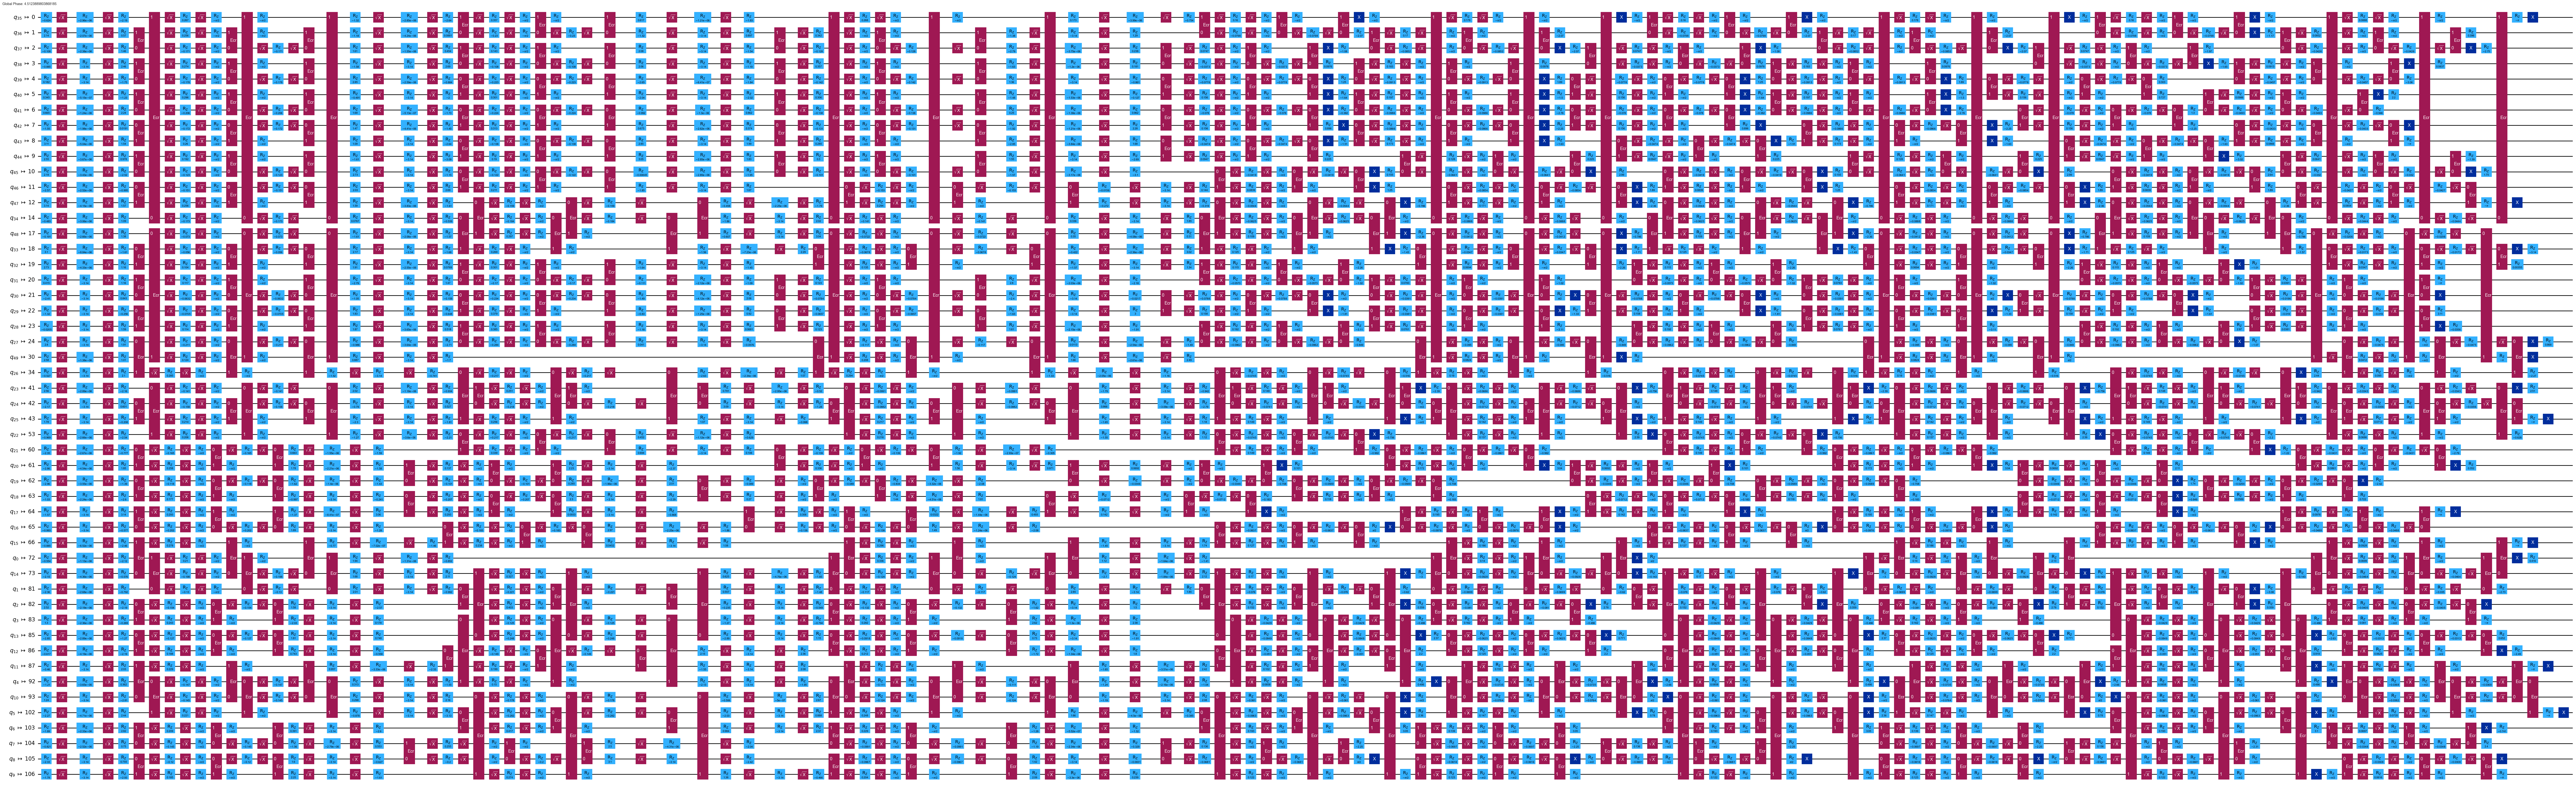

In [36]:
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pass_manager.run(aqc_final_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
print("Observable info:", isa_observable)
print("Circuit depth:", isa_circuit.depth())
isa_circuit.draw("mpl", fold=-1, idle_wires=False)

Observable info: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
Circuit depth: 158


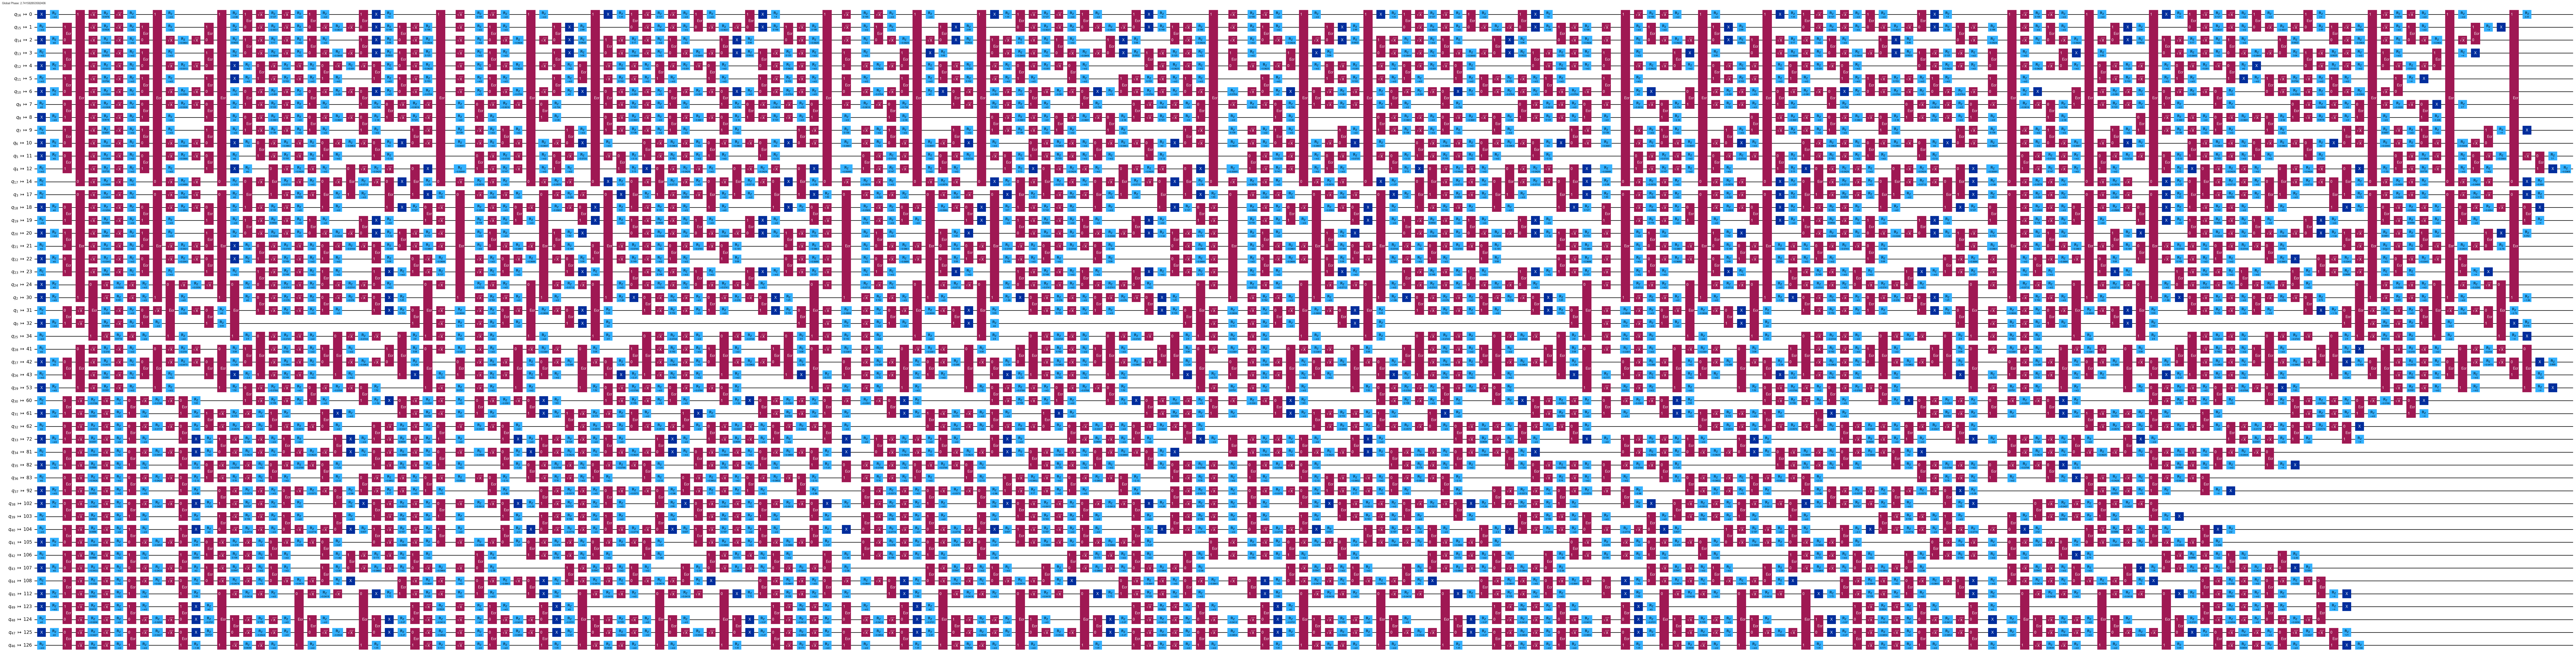

In [37]:
isa_comparison_circuit = pass_manager.run(aqc_comparison_circuit)
isa_comparison_observable = observable.apply_layout(isa_comparison_circuit.layout)
print("Observable info:", isa_comparison_observable)
print("Circuit depth:", isa_comparison_circuit.depth())
isa_comparison_circuit.draw("mpl", fold=-1, idle_wires=False)

### Step 3. Qiskit Primitives を使用して実行

このステップでは、トランスパイルされた回路を量子ハードウェア（またはシミュレートされたバックエンド）で実行し、`qiskit_ibm_runtime` の `EstimatorV2` を使用して指定されたオブザーバブルを測定します。ジョブの結果は、ターゲットハードウェア上での回路の性能に関する貴重な洞察を提供します。

この大規模な例では、 `EstimatorOptions` を利用してハードウェア実験のパラメータをより適切に管理・制御する方法を探ります。これらの設定はオプションですが、実験パラメータの追跡や、最適な結果を得るための実行オプションを洗練させるのに役立ちます。

利用可能な実行オプションの完全なリストについては、[qiskit-ibm-runtime のドキュメント](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions) を参照してください。

In [38]:
twirling_options = {
    "enable_gates": True,
    "enable_measure": True,
    "num_randomizations": 300,
    "shots_per_randomization": 100,
    "strategy": "active",
}

zne_options = {
    "amplifier": "gate_folding",
    "noise_factors": [1, 2, 3],
    "extrapolated_noise_factors": list(np.linspace(0, 3, 31)),
    "extrapolator": ["exponential", "linear", "fallback"],
}

meas_learning_options = {"num_randomizations": 512, "shots_per_randomization": 512}

resilience_options = {
    "measure_mitigation": True,
    "zne_mitigation": True,
    "zne": zne_options,
    "measure_noise_learning": meas_learning_options,
}

estimator_options = {
    "resilience": resilience_options,
    "twirling": twirling_options,
}

estimator = Estimator(backend, options=estimator_options)

In [39]:
job = estimator.run([(isa_circuit, isa_observable)])
print("Job ID:", job.job_id())
job.result()

Job ID: cwss0vv5v39g008hd7m0


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

In [40]:
job_comparison = estimator.run([(isa_comparison_circuit, isa_observable)])
print("Job Comparison ID:", job.job_id())
job_comparison.result()

Job Comparison ID: cwss0vv5v39g008hd7m0


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(3, 31), dtype=float64>)), metadata={'shots': 30000, 'target_precision': 0.005773502691896258, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'exponential'}}, 'num_randomizations': 300})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 300, 'shots_per_randomization': 100, 'interleave_randomizations': True, 'strategy': 'active'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': Tru

### Step 4: 後処理を行い、結果を希望する古典形式で返す

ここでは、以前と同様に再構築は必要なく、実行結果から直接期待値にアクセスして結果を確認することができます。

In [41]:
# AQC results
hw_results = job.result()
hw_results_dicts = [pub_result.data.__dict__ for pub_result in hw_results]
hw_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_results_dicts]
aqc_expval = hw_expvals[0]

# AQC comparison results
hw_comparison_results = job_comparison.result()
hw_comparison_results_dicts = [pub_result.data.__dict__ for pub_result in hw_comparison_results]
hw_comparison_expvals = [pub_result_data["evs"].tolist() for pub_result_data in hw_comparison_results_dicts]
aqc_compare_expval = hw_comparison_expvals[0]

print(f"Exact:         \t{reference_expval:.4f}")
print(f"AQC:           \t{aqc_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_expval):.4f}")
print(f"AQC Comparison:\t{aqc_compare_expval:.4f}, |∆| = {np.abs(reference_expval- aqc_compare_expval):.4f}")

Exact:         	-0.5888
AQC:           	-0.5817, |∆| = 0.0071
AQC Comparison:	0.9790, |∆| = 1.5678


Plotting the results of the AQC, comparison, and exact circuits for the 50-site XXZ model.


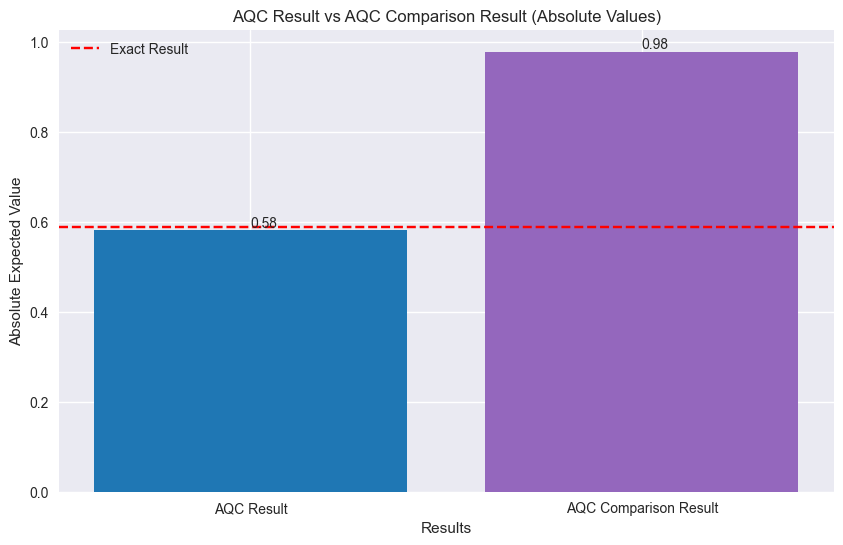

In [42]:
labels = ['AQC Result', 'AQC Comparison Result']
values = [abs(aqc_expval), abs(aqc_compare_expval)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['tab:blue', 'tab:purple'])
plt.axhline(y=abs(reference_expval), color='red', linestyle='--', label='Exact Result')
plt.xlabel('Results')
plt.ylabel('Absolute Expected Value')
plt.title('AQC Result vs AQC Comparison Result (Absolute Values)')
plt.legend()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()

## 結論

このチュートリアルでは、テンソルネットワークを用いた近似量子コンパイル（Approximate Quantum Compilation, AQC-Tensor）を使用して、量子力学のシミュレーションのために回路を圧縮および最適化する方法を示しました。小規模および大規模なハイゼンベルグモデルを利用し、AQC-Tensorを適用してトロッター展開による時間発展に必要な回路の深さを削減しました。簡略化されたトロッター回路からパラメトリックアンサッツを生成し、行列積状態（MPS）技術で最適化することによって、ターゲットの時間発展を低深度で正確かつ効率的に近似しました。

ここでのワークフローは、量子シミュレーションをスケーリングするためのAQC-Tensorの主な利点を強調しています：

* **大幅な回路圧縮**：AQC-Tensorは、複雑な時間発展に必要な回路の深度を削減し、現在のデバイスでの実行可能性を向上させました。
* **効率的な最適化**：MPSアプローチは、忠実度と計算効率のバランスを取るパラメータ最適化のための堅牢なフレームワークを提供しました。
* **ハードウェア対応の実行**：最終的に最適化された回路をトランスパイルすることで、ターゲット量子ハードウェアの制約に適合させました。

今後、より大規模な量子デバイスや高度なアルゴリズムが登場する中で、AQC-Tensorのような技術は、近未来の量子ハードウェアで複雑な量子シミュレーションを実行するために不可欠なものとなり、スケーラブルな量子アプリケーションにおける深さと忠実度の管理において有望な進展を示すことになるでしょう。

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td valign="top" style="width: 10%;"><img src="https://learning-api.quantum.ibm.com/assets/53171443-b07b-4ae6-a4be-9aec32a854f5" alt="Survey" width="100%" height="100%"></td>
<td valign="top"  style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_eF01c2sfeSt6cqq" target="_blank">Tutorial Survey</a></strong><p><p>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>
